## Tennis Match Prediction

The website http://tennis-data.co.uk/alldata.php gathers outcomes of both WTA (Women
Tennis Association) and ATP (Association of Tennis Professionals - men only) tennis games
over several years.
A short description of each variable can be found here :
http://www.tennis-data.co.uk/notes.txt

The aim of this notebook is to predict the oucomes of matches played during the year 2017

#### Data Preparation

###### Importing Libraries and Reading the Dataset

In [1]:
import pandas as pd
from urllib.request import urlopen  
import os.path as osp
import os
import logging
import zipfile
from glob import glob
logging.getLogger().setLevel('INFO')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import datetime
import matplotlib.patches as mpatches
import category_encoders as ce
import swifter
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

###### Download the dataset

In [2]:
def download_file(url_str, path):
    url = urlopen(url_str)
    output = open(path, 'wb')       
    output.write(url.read())
    output.close()  
    
def extract_file(archive_path, target_dir):
    zip_file = zipfile.ZipFile(archive_path, 'r')
    zip_file.extractall(target_dir)
    zip_file.close()

In [3]:
BASE_URL = 'http://tennis-data.co.uk'
DATA_DIR = "tennis_data"
ATP_DIR = './{}/ATP'.format(DATA_DIR)
WTA_DIR = './{}/WTA'.format(DATA_DIR)

ATP_URLS = [BASE_URL + "/%i/%i.zip" % (i,i) for i in range(2000,2019)]
WTA_URLS = [BASE_URL + "/%iw/%i.zip" % (i,i) for i in range(2007,2019)]

os.makedirs(osp.join(ATP_DIR, 'archives'), exist_ok=True)
os.makedirs(osp.join(WTA_DIR, 'archives'), exist_ok=True)

for files, directory in ((ATP_URLS, ATP_DIR), (WTA_URLS, WTA_DIR)):
    for dl_path in files:
        logging.info("downloading & extracting file %s", dl_path)
        archive_path = osp.join(directory, 'archives', osp.basename(dl_path))
        download_file(dl_path, archive_path)
        extract_file(archive_path, directory)
    
ATP_FILES = sorted(glob("%s/*.xls*" % ATP_DIR))
WTA_FILES = sorted(glob("%s/*.xls*" % WTA_DIR))

df_atp = pd.concat([pd.read_excel(f) for f in ATP_FILES], ignore_index=True)
df_wta = pd.concat([pd.read_excel(f) for f in WTA_FILES], ignore_index=True)

logging.info("%i matches ATP in df_atp", df_atp.shape[0])
logging.info("%i matches WTA in df_wta", df_wta.shape[0])

INFO:root:downloading & extracting file http://tennis-data.co.uk/2000/2000.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2001/2001.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2002/2002.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2003/2003.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2004/2004.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2005/2005.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2006/2006.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2007/2007.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2008/2008.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2009/2009.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2010/2010.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2011/2011.zip
INFO:root:downloading & extracting file http://tenni

In [4]:
df_atp.tail()

,ATP,AvgL,AvgW,B&WL,B&WW,B365L,B365W,Best of,CBL,CBW,...,UBW,W1,W2,W3,W4,W5,WPts,WRank,Winner,Wsets
52293,67,3.14,1.38,NaN,NaN,3.20,1.36,3,NaN,NaN,...,NaN,7.0,6,NaN,NaN,NaN,5085.0,5,Zverev A.,2.0
52294,67,5.14,1.17,NaN,NaN,4.50,1.20,3,NaN,NaN,...,NaN,7.0,6,NaN,NaN,NaN,8045.0,1,Djokovic N.,2.0
52295,67,1.38,3.14,NaN,NaN,1.36,3.20,3,NaN,NaN,...,NaN,7.0,7,NaN,NaN,NaN,5085.0,5,Zverev A.,2.0
52296,67,6.52,1.12,NaN,NaN,7.00,1.11,3,NaN,NaN,...,NaN,6.0,6,NaN,NaN,NaN,8045.0,1,Djokovic N.,2.0
52297,67,1.15,5.69,NaN,NaN,1.14,5.50,3,NaN,NaN,...,NaN,6.0,6,NaN,NaN,NaN,5085.0,5,Zverev A.,2.0


###### Basic Information about Dataset


In [5]:
print(df_atp.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52298 entries, 0 to 52297
Data columns (total 54 columns):
ATP           52298 non-null int64
AvgL          22745 non-null float64
AvgW          22745 non-null float64
B&WL          1097 non-null float64
B&WW          1097 non-null float64
B365L         43666 non-null float64
B365W         43643 non-null float64
Best of       52298 non-null int64
CBL           17506 non-null float64
CBW           17506 non-null float64
Comment       52298 non-null object
Court         52298 non-null object
Date          52298 non-null datetime64[ns]
EXL           39416 non-null float64
EXW           39411 non-null object
GBL           5055 non-null float64
GBW           5055 non-null float64
IWL           13358 non-null float64
IWW           13358 non-null float64
L1            52037 non-null float64
L2            51527 non-null object
L3            24168 non-null object
L4            4731 non-null float64
L5            1791 non-null float64
LBL        

Some important information:
* There are 54 columns in the dataset.
* There are 52298 samples in total. It is quite large.
* There are no null records in categorical data. It's good.
* There are null records in numeric data.
* The type of some columns is not correct (Lsets, Wsets...).
* Some columns are not knowable before the end of the match (Loser, Winner, L1, L2, W1, W2,...).
* Data types are int64, float64, datetime64[ns] and object.
* Memory usage: 21.5 MB.

#### Correcting data 

###### Which features may contain errors or typos?

This is harder to review for a large dataset, however reviewing a few samples from a smaller dataset may just tell us outright, which features may require correcting.

The columns [L1, L2, L3, L4, L5, W1, W2, W3, W4, W5] are not knowable before the start of the match, 
I cannot use them directly to predict who is the winner, but I can use them to generate new features. I notice that [L2, W2, L3, W3] are categorical. I have to convert them into numeric format.

In [6]:
for i in range(2,4):
    print('Distinct values of L{} are : {}'.format(i,df_atp['L'+str(i)].unique()))
    print('Distinct values of W{} are : {}'.format(i,df_atp['W'+str(i)].unique()))
    print('---'*23)

Distinct values of L2 are : [2.0 3.0 5.0 4.0 7.0 6.0 1.0 0.0 nan ' ']
Distinct values of W2 are : [6.0 7.0 5.0 2.0 4.0 nan 0.0 3.0 1.0 ' ']
---------------------------------------------------------------------
Distinct values of L3 are : [nan 3.0 4.0 1.0 2.0 6.0 0.0 5.0 7.0 ' ']
Distinct values of W3 are : [nan 6.0 7.0 3.0 1.0 4.0 2.0 5.0 0.0 ' ']
---------------------------------------------------------------------


In [7]:
#Replace empty values in column ['L2','L3','W3','W2']  by NaN
df_atp[['L2','L3','W3','W2']] = df_atp[['L2','L3','W3','W2']].replace(' ',np.NaN)

The missing values in these collones imply that the players are not playing this sets. Then, I'm going to replace the missing values in these columns by zero

In [8]:
games_columns = ['L1','L2','L3','L4','L5','W1','W2','W3','W4','W5']
df_atp[games_columns]=df_atp[games_columns].fillna(0)

I also note that the columns ['LRank', 'WRank'] are categorical, whereas normally they must be of numeric type. I check why this arrived.

In [9]:
print('The number of occurrences of each element in df_atp["LRank"] : \n', df_atp.groupby(['LRank']).size())
print('\nThe number of occurrences of each element in df_atp["WRank"] : \n', df_atp.groupby(['WRank']).size())

The number of occurrences of each element in df_atp["LRank"] : 
 LRank
1         208
2         233
3         297
4         309
5         352
         ... 
1848.0      1
1855.0      1
1890.0      1
2159.0      1
NR         27
Length: 943, dtype: int64

The number of occurrences of each element in df_atp["WRank"] : 
 WRank
1         1172
2         1044
3          979
4          891
5          915
          ... 
1277.0       1
1554.0       1
1821         1
1890         1
NR           1
Length: 604, dtype: int64


I note that the players without rank are noted $NR$. Generally, these players with rank higher than the maximum of the assigned ranks. Maybe I can estimate them in relation to the maximum of the assigned ranks.

In [10]:
rank_col = ['WRank','LRank']
df_atp[rank_col] = df_atp[rank_col].replace('NR', -1)
df_atp[rank_col] = df_atp[rank_col].replace(-1, max(max(df_atp["LRank"].astype(float)),max(df_atp["WRank"].astype(float))))

Now, I'm going to delete the columns that contain a lot of missing values. I chose a threshold of 60%. So all features that contain more than 60% missing values will be deleted.

However, before that, I check the distribution of missing values: On the figure below we notice that the matches played before the year 2006 contain more missing values.

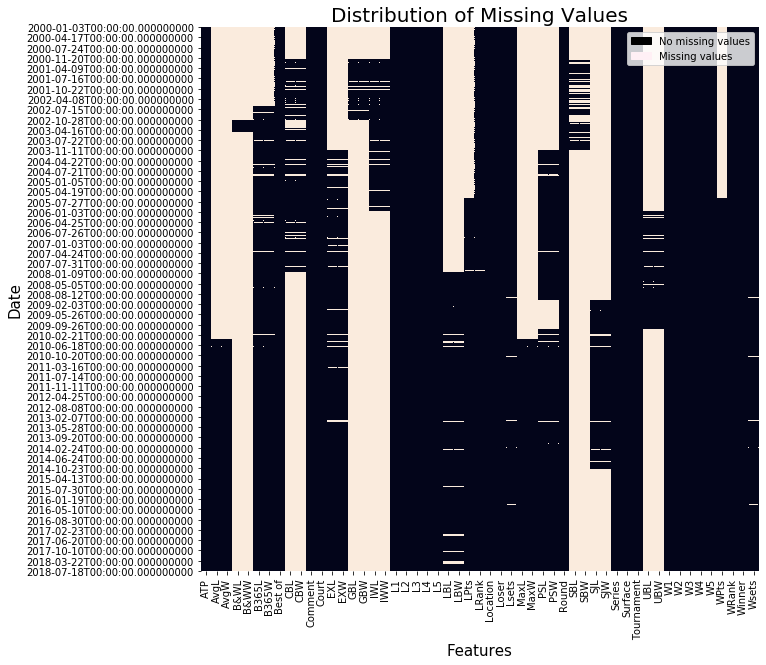

In [11]:
plt.figure(figsize=((10,10)))
ax = plt.axes()
#df_atp.set_index('Date')
sns.heatmap(df_atp.set_index('Date').isnull(), cbar=False)#.iloc[:,:int(df.shape[1]/2)*/
ax.set_title('Distribution of Missing Values',fontsize = 20)
plt.xlabel('Features', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('Date', fontsize = 15) # y-axis label with fontsize 15
#xtickformat('mm:ss')
balck_patch = mpatches.Patch(color='black', label='No missing values')
lavenderblush_patch = mpatches.Patch(color='lavenderblush', label='Missing values')
plt.legend(handles=[balck_patch,lavenderblush_patch],loc='best')
plt.show()

I choose to delete columns that contain more then 60%  of missing values.

In [12]:
thresh = len(df_atp) * 0.6
df_atp=df_atp.dropna(axis=1, thresh=thresh)
# View columns in the dataset
print('\nThe remaining columns in df_atp :  \n\n', np.array(df_atp.columns))


The remaining columns in df_atp :  

 ['ATP' 'B365L' 'B365W' 'Best of' 'Comment' 'Court' 'Date' 'EXL' 'EXW' 'L1'
 'L2' 'L3' 'L4' 'L5' 'LPts' 'LRank' 'Location' 'Loser' 'Lsets' 'PSL' 'PSW'
 'Round' 'Series' 'Surface' 'Tournament' 'W1' 'W2' 'W3' 'W4' 'W5' 'WPts'
 'WRank' 'Winner' 'Wsets']


In [13]:
df_atp.dtypes

ATP                    int64
B365L                float64
B365W                float64
Best of                int64
Comment               object
Court                 object
Date          datetime64[ns]
EXL                  float64
EXW                   object
L1                   float64
L2                   float64
L3                   float64
L4                   float64
L5                   float64
LPts                 float64
LRank                float64
Location              object
Loser                 object
Lsets                 object
PSL                  float64
PSW                  float64
Round                 object
Series                object
Surface               object
Tournament            object
W1                   float64
W2                   float64
W3                   float64
W4                   float64
W5                   float64
WPts                 float64
WRank                float64
Winner                object
Wsets                float64
dtype: object

In the remaining columns, I notice that the columns [Lsets, EXW] are of type categorical, whereas they must be of numerical type. I check the erroneous recordings

In [14]:
print( '\nThe distinct values of df_atp["Lsets"] are : \n\n',df_atp['Lsets'].unique())

print( '\n\nThe distinct values of df_atp["EXW"] are : \n',df_atp['EXW'].unique())


The distinct values of df_atp["Lsets"] are : 

 [0 1 2 nan '`1']


The distinct values of df_atp["EXW"] are : 
 [nan 1.48 1.2 1.5 1.8 1.9 1.75 1.65 1.55 2.45 3.12 2.67 2.1 2.15 1.28 2.0
 2.6 1.7 1.85 2.3 2.71 1.45 1.15 1.17 1.71 1.42 2.53 1.6 1.3 1.23 1.25 1.4
 2.85 1.1 1.35 1.95 3.1 4.25 2.31 2.35 2.92 1.11 3.46 1.05 2.05 2.2 7.25
 1.37 1.67 3.98 1.14 3.35 3.81 2.75 1.18 3.75 1.78 1.02 1.22 2.56 2.34
 1.44 1.07 1.32 1.21 2.25 1.04 1.06 1.13 2.17 1.26 1.53 2.83 1.19 4.67
 1.27 1.47 2.28 2.65 1.03 1.39 2.4 1.49 3.0 1.76 1.58 1.36 1.63 1.34 5.2
 1.33 3.22 2.03 3.05 6.75 4.06 2.9 5.15 1.12 2.5 2.8 1.81 1.08 3.01 1.38
 1.24 6.25 5.85 3.45 2.12 1.91 1.56 1.99 1.87 1.43 2.7 7.19 7.79 3.89 5.84
 1.51 2.72 2.07 1.16 3.63 1.61 1.97 1.09 1.46 3.6 1.83 3.4 3.17 2.08 5.5
 7.75 2.46 3.59 2.38 1.64 2.63 3.72 1.41 1.571 1.93 8.5 2.23 1.77 0.0 4.92
 1.01 1.54 3.34 2.62 5.9 3.3 6.68 2.55 1.68 2.88 1.115 1.72 4.4 1.415 2.87
 2.82 3.74 2.79 3.37 1.73 1.005 1.57 3.595 2.29 1.66 2.21 10.5 1.62 5.34
 3.9 2

The values "` 1 "and" 2., 3 " are poorly written, then I am going to replace them with 1 and 2.3 respectively.

In [15]:
df_atp[["Lsets"]]=df_atp[["Lsets"]].replace("`1",1)
df_atp[["EXW"]]=df_atp[["EXW"]].replace("2.,3",2.3)

I can now check that all the columns have the correct type.

In [16]:
df_atp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52298 entries, 0 to 52297
Data columns (total 34 columns):
ATP           52298 non-null int64
B365L         43666 non-null float64
B365W         43643 non-null float64
Best of       52298 non-null int64
Comment       52298 non-null object
Court         52298 non-null object
Date          52298 non-null datetime64[ns]
EXL           39416 non-null float64
EXW           39411 non-null float64
L1            52298 non-null float64
L2            52298 non-null float64
L3            52298 non-null float64
L4            52298 non-null float64
L5            52298 non-null float64
LPts          36035 non-null float64
LRank         52220 non-null float64
Location      52298 non-null object
Loser         52298 non-null object
Lsets         52073 non-null float64
PSL           37339 non-null float64
PSW           37339 non-null float64
Round         52298 non-null object
Series        52298 non-null object
Surface       52298 non-null object
Tournam

Now that all my columns are in good typos, I assign to each null record a value "mean", "median"  or mode columns to the existence of outlier or not.

In [17]:
print('\nDescription of each feature :\n\n',df_atp.describe().iloc[:,:15])
print(df_atp.describe().iloc[:,15:])


Description of each feature :

                 ATP         B365L         B365W       Best of           EXL  \
count  52298.000000  43666.000000  43643.000000  52298.000000  39416.000000   
mean      33.222532      3.551805      1.823768      3.372366      3.262180   
std       18.115493      3.527564      1.100806      0.778516      2.449627   
min        1.000000      1.002000      1.000000      3.000000      1.000000   
25%       19.000000      1.720000      1.222000      3.000000      1.750000   
50%       33.000000      2.500000      1.500000      3.000000      2.460000   
75%       49.000000      4.000000      2.075000      3.000000      3.750000   
max       69.000000    101.000000     29.000000      5.000000     40.000000   

                EXW            L1            L2            L3            L4  \
count  39411.000000  52298.000000  52298.000000  52298.000000  52298.000000   
mean       1.802502      4.035986      3.815423      1.660159      0.349497   
std        0.95903

In [18]:
# Replace the missing values of the following columns by the mean ()
col_mean_na = ['LPts','WPts']
# Replace the missing values of the following columns by the mode()
col_mode_na = ['Lsets', 'Wsets']
# Replace the missing values of the following columns by the median()
col_median_na = ['B365L', 'B365W','EXL', 'EXW', 'LRank','PSL', 'PSW','WRank']

In [19]:
def complete_na_columns(df,col_mean_na,col_mode_na,col_median_na):
    
    '''
    This function takes argument dataset df, colomuns which to replace missing values by mean,
    mode and mediane.
    return the desired transformation.
    '''
    
    df[col_mean_na] = df[col_mean_na].fillna(df[col_mean_na].mean())
    df[col_mode_na] = df[col_mode_na].fillna(df[col_mode_na].mode().iloc[0])
    df[col_median_na] = df[col_median_na].fillna(df[col_median_na].median())
    return df

df_atp = complete_na_columns(df_atp,col_mean_na,col_mode_na,col_median_na)

As we can see now, the columns do not contain any missing values.

In [20]:
print('There is {} missing value(s) in df_atp '.format(df_atp.isnull().sum().sum()))

There is 0 missing value(s) in df_atp 


I remind that the aim of this work is to predict the winners of matches in the year 2017. the current content of my dataset does not allow me to train my models well because we cannot provide some features before 
start of the match, otherwise the training will be biased. So I will proceed to some regularizations

In [21]:
def transform_df(df):
    
    '''
    Thid function define a new dataset adapted to the knowledge which I have before the start of each match
    '''
    
    # Initialized the new dataset
    new_df = pd.DataFrame()
    
    # ignore 2018 matches
    #I will consider the matches played in 2018 as unknowns in the prediction.
    #So I will not take them into account
    date = datetime.datetime(2017,12,31)
    df = df[df['Date']<=date]
    
    
    #By default, I assume that player 1 has lost and player 2 has won 
    new_df[['Player1','Player2']]= df[['Loser','Winner']]
    
    # I choose randomly one of players (Loser or Winner) to represent Player1 and the other 
    # to represent Player2
    new_df[['Player1','Player2']] = [np.random.choice([x,y],2, replace=False,
                                          p=[0.5,0.5]) for x,y in zip(df['Loser'],df['Winner'])]
    '''
    I will assign the information about each player by ignoring whether he is the winner or the loser for
    avoid bias. I assume Player1 by default is the loser and I attribute the features.
    If what I assumed by default is false I reverse the attribution of features.
    '''
    
    columns_1 =['B365W','B365L','EXW','EXL','PSW', 'PSL','WPts','WRank','LPts','LRank']
    columns_2 = ['B365L','B365W','EXL','EXW','PSL', 'PSW','LPts','LRank','WPts','WRank']
    new_df_col = ['B365P1','B365P2','EXP1','EXP2','PSP1', 'PSP2','P1Pts','P1Rank','P2Pts','P2Rank']
    new_df[new_df_col] = df[columns_2]
    condition = new_df['Player1']==df['Winner']
    new_df[new_df_col] = np.where(np.array([condition]*10).T, df[columns_1], df[columns_2])
    
    # Create a target (Outcome) equal to 1 if player1 wins or 0 if player 1 loses
    new_df["Outcome"] = np.where(new_df['Player1']==df['Winner'], 1, 0)
    
    # The other features remain unchanged
    others_columns_1 = ['L1','L2','L3','L4','L5','W1','W2','W3','W4','W5']
    others_columns_2 = list(df.select_dtypes(include=['int64', 'object', 'datetime64[ns]']).columns)
    new_df[others_columns_1+others_columns_2]=df[others_columns_1+others_columns_2]
    
    return new_df

Now, I create the function $ create\_new\_features$ which will generate new features

In [22]:
def statistics_player(player,date,dataset):
    
    '''
    This function takes 3 arguments :
    player : the name of player
    date : the date of the match
    dataset : df in our case
    
    return:
    num_matches_before : Number of matches played by the player before the start of the match
    num_wins_before    : Number of matches won by the player before the start of the match
    num_games_won      : Number of games (in sets) won by the player before the start of the match
    '''
    games_winner = ['W1','W2','W3','W4','W5']
    games_loser = ['L1','L2','L3','L4','L5']
    
    num_matches_before = len(dataset[((dataset.Player1 == player) | (dataset.Player2 == player))
                                     & (dataset.Date < date)])
    
    num_wins_before =  len(dataset[(((dataset.Player1 == player) & (dataset.Outcome == 1))
                                                         | ((dataset.Player2 == player) & (dataset.Outcome == 0)))
                                                        & (dataset.Date < date)])
    
    num_games_won = dataset[(((dataset.Player1 == player) & (dataset.Outcome == 1))
                             | ((dataset.Player2 == player) & (dataset.Outcome == 0)))
                            & (dataset.Date<date)][games_winner].sum().sum() + dataset[(((dataset.Player1 == player) & (dataset.Outcome==0))
                                                                                        | ((dataset.Player2 == player) & (dataset.Outcome==1)))
                                                                                       & (dataset.Date < date)][games_loser].sum().sum()
    
    return num_matches_before, num_wins_before, num_games_won

def direct_confrontation(player1, player2, date, tournament, dataset):
    
    '''
    This function takes 4 arguments :
    player1 : Name of palayer 1
    player2 : Name of palayer 2
    date    : Date of the match
    dataset : df in our case
    
    and returns:
    WinsP1 : Number of matches won by player1 against player2
    WinsP2 : Number of matches won by player2 against player1
    '''
    WinsP1 = len(dataset[(((dataset.Player1 == player1) & (dataset.Player2 == player2)
                         &(dataset.Outcome == 1))
                       | ((dataset.Player2 == player1) & (dataset.Player1 == player2)
                        &(dataset.Outcome == 0))) & (dataset.Date < date)])
    
    WinsP1TR = len(dataset[(((dataset.Player1 == player1) & (dataset.Player2 == player2)
                           &(dataset.Outcome == 1))
                          | ((dataset.Player2 == player1) & (dataset.Player1 == player2)
                             &(dataset.Outcome == 0))) & (dataset.Date < date)&(dataset.Tournament == tournament)])
    
    WinsP2 = len(dataset[(((dataset.Player1 == player2) & (dataset.Player2 == player1)
                         &(dataset.Outcome == 1))
                       | ((dataset.Player2 == player2) & (dataset.Player1 == player1)
                        &(dataset.Outcome == 0))) & (dataset.Date < date)])
    WinsP2TR = len(dataset[(((dataset.Player1 == player2) & (dataset.Player2 == player1)
                           &(dataset.Outcome == 1))
                          | ((dataset.Player2 == player2) & (dataset.Player1 == player1)
                             &(dataset.Outcome == 0))) & (dataset.Date < date)&(dataset.Tournament == tournament)])
    
    return WinsP1, WinsP2, WinsP1TR, WinsP2TR
                         
def create_new_features(df):
    
    new_df = transform_df(df)
    games_winner = ['W1','W2','W3','W4','W5']
    games_loser = ['L1','L2','L3','L4','L5']
    
    '''
    create the features : 
    NuMatchesP1 : Number of matches played by Player1 before the start of the match
    NumWinsP1   : Number of matches won by Player1 before the start of the match
    TotalGamesP1 : Number of games (in sets) won by Player1 before the start of the match
    '''
    new_df['NuMatchesP1'], new_df['NumWinsP1'],new_df['TotalGamesP1'] = zip(*new_df.swifter.apply
                                                                            (lambda x: statistics_player(x.Player1,
                                                                                                         x.Date,new_df), axis=1))
    
    '''
    create the features : 
    NuMatchesP2 : Number of matches played by Player2 before the start of the match
    NumWinsP2   : Number of matches won by Player2 before the start of the match
    TotalGamesP2 : Number of games (in sets) won by Player2 before the start of the match
    '''
    new_df['NuMatchesP2'], new_df['NumWinsP2'],new_df['TotalGamesP2'] = zip(*new_df.swifter.apply
                                                                            (lambda x: statistics_player(x.Player2,
                                                                                                         x.Date,new_df), axis=1))
    
    
    # Create the feature 'WinsRatioP1': Win ratio of Player1
    new_df['WinsRatioP1'] = new_df['NumWinsP1'] / new_df['NuMatchesP1']
    # Create the feature 'WinsRatioP2': Win ratio of Player2
    new_df['WinsRatioP2'] = new_df['NumWinsP2'] / new_df['NuMatchesP2']
    # Replace infinity with zero if they exists
    new_df.loc[~np.isfinite(new_df['WinsRatioP1']), 'WinsRatioP1'] = 0
    new_df.loc[~np.isfinite(new_df['WinsRatioP2']), 'WinsRatioP2'] = 0
    new_df['P1Wins'], new_df['P2Wins'],new_df['P1WinsTR'], new_df['P2WinsTR'] = zip(*new_df.swifter.apply
                                             (lambda x: direct_confrontation(x.Player1, x.Player2,
                                                                             x.Date , x.Tournament, new_df), axis=1))
    # Replace NaN with zero if they exists
    new_df[['WinsRatioP1','WinsRatioP2']]=new_df[['WinsRatioP1','WinsRatioP2']].fillna(0)
    
    #Create features 'LengthNameP1' and LengthNameP2' based on length name of players. As Europeans are
    #the best in tennis. I guess European names are more likely to win a match than Asians, for example,
    #who have names that are too short. 
    
    new_df['LengthNameP1']= new_df['Player1'].str.len()
    new_df['LengthNameP2']= new_df['Player2'].str.len()
    
    # Delete features that cannot be identified before the start of the match
    # I can probably remove the feature "ATP" which is just a tournament numbering
    # and do not contribute to the prediction
    new_df.drop(games_winner + games_loser + ['Winner','Loser','ATP'] , axis=1, inplace=True)
    
    return new_df
df = create_new_features(df_atp)

/Users/hajjimohammed/opt/anaconda3/lib/python3.7/site-packages/tqdm/std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel



as we see, no column contains null values now.

In [23]:
print('There is {} missing value(s) in df '.format(df.isnull().sum().sum()))

There is 0 missing value(s) in df 


### DATA VISUALIZATION TO UNDERSTAND THE DATASET

#### Correlation Matrix


A correlation matrix is used to assess the dependence between several features at the same time. The result is a table containing the correlation coefficients between each feature and the others.

This is the correlation matrix of my dataset :

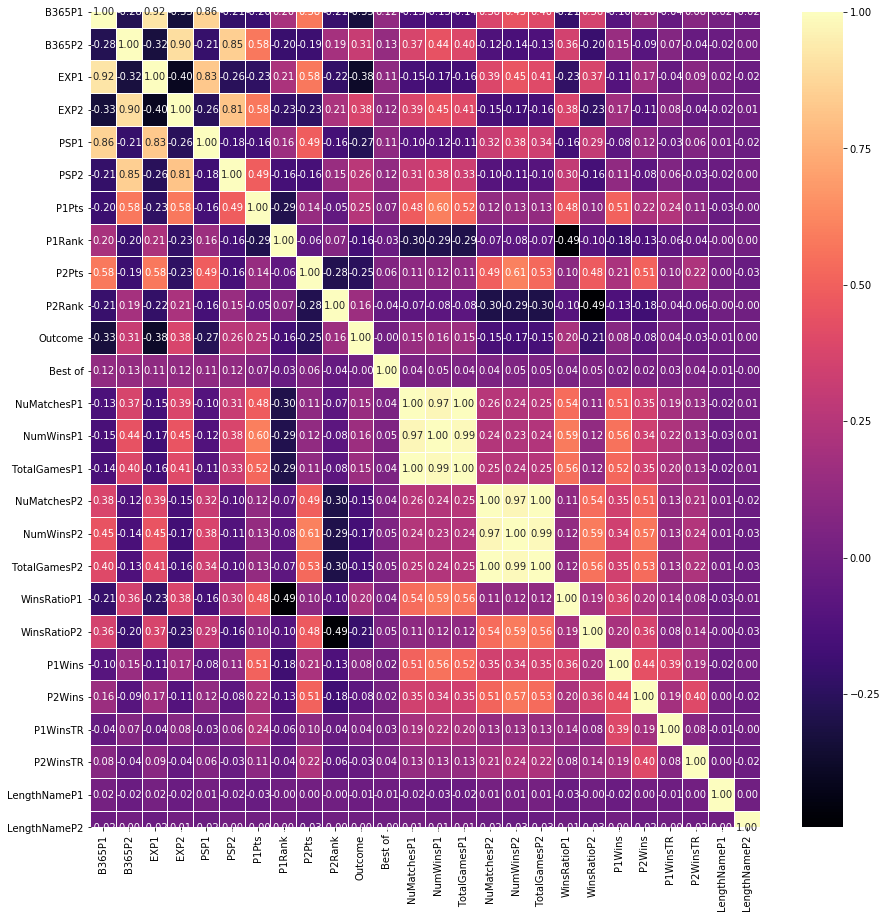

In [24]:
bins = np.linspace(0, 300, 20)
fig,ax = plt.subplots(figsize=(15, 15))
sns.heatmap(df.corr(), ax=ax, annot=True, linewidths=0.05, fmt= '.2f',cmap="magma")
plt.show()

Features with high correlation are more linearly dependent and hence have almost the same effect on the dependent variable. So, when two features have high correlation, we can drop one of the two features.

Next, I compare the correlation between features and remove one of two features that have a correlation higher than 0.9.

/Users/hajjimohammed/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


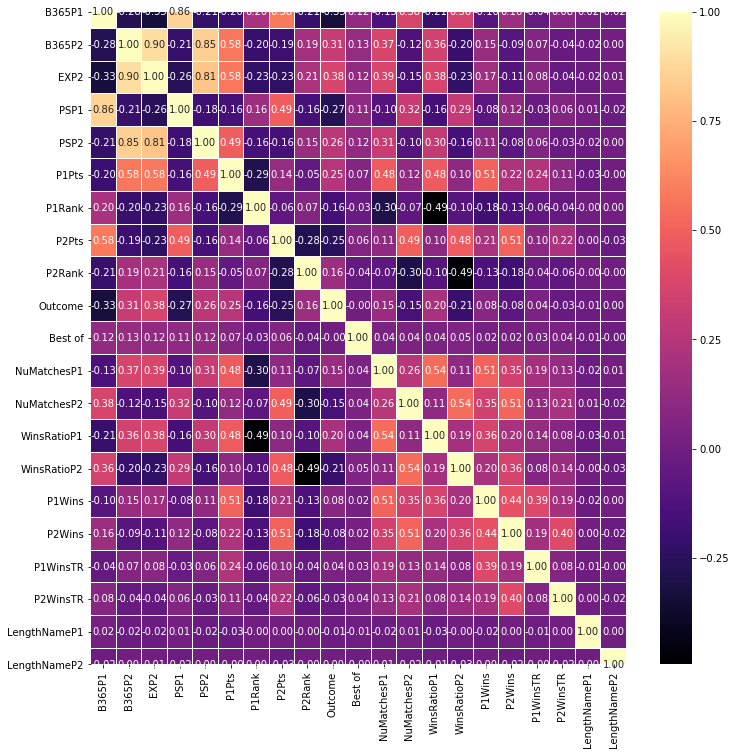

In [26]:
corr = df.corr()
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = df.select_dtypes(include=['int64', 'float64']).columns[columns]#
# I keep columns Player1 and Player2
player1=df['Player1']
player2=df['Player2']
# I select the columns except those with more than 0.9 correlation
df = df[selected_columns]
# I add the resatante columns of type object and the column Date
df['Player1']= player1
df['Player2']= player2
#I will not take into account the matches of 2018
date = datetime.datetime(2017,12,31)
df[list(df_atp.select_dtypes(include=['object','datetime64[ns]']).columns
       )] = df_atp[df_atp['Date']<= date][list(df_atp.select_dtypes(include=['object','datetime64[ns]'])
                                                .columns)]
fig,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(df.corr(), ax=ax, annot=True, linewidths=0.05, fmt= '.2f',cmap="magma")
plt.show()

#### Discovering ranks of players

I can conclude from the scatter plots below that the majority of players have a rank between 1 and 250.

/Users/hajjimohammed/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


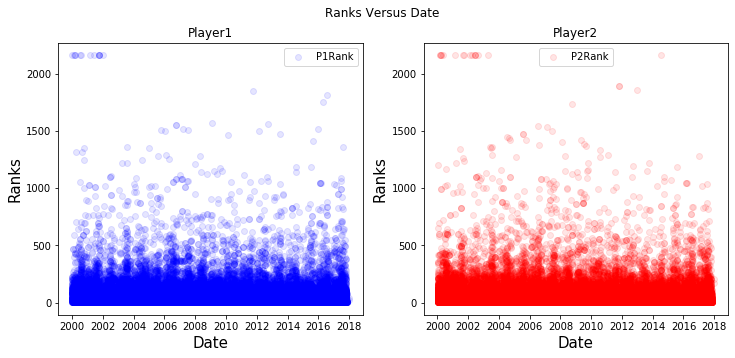

In [27]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,5))
fig.suptitle('Ranks Versus Date')
ax1.plot_date(y='P1Rank',x='Date',fmt='o',data=df,color='blue',alpha=0.1)#,style='.', color = 'red', ax=ax1)
ax2.plot_date(y='P2Rank',x='Date',fmt='o',data=df,color='red',alpha=0.1)
ax1.set_title('Player1')
ax2.set_title('Player2')
ax1.set_xlabel('Date', fontsize = 15) # x-axis label with fontsize 15
ax1.set_ylabel('Ranks', fontsize = 15) # y-axis label with fontsize 15
ax2.set_xlabel('Date', fontsize = 15) # x-axis label with fontsize 15
ax2.set_ylabel('Ranks', fontsize = 15) # y-axis label with fontsize 15
ax1.legend()
ax2.legend()

#### Discovering points of players


I also note from the scatter plot below that the points awarded to the players started from the year 2005. Which explains the absence of values in the dataset before this year.

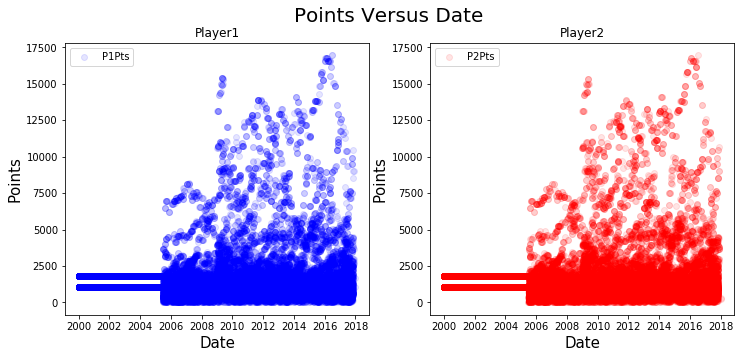

In [28]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,5))
fig.suptitle('Points Versus Date',fontsize = 20)
ax1.plot_date(y='P1Pts',x='Date',fmt='o',data=df,color='blue',alpha=0.1)
ax2.plot_date(y='P2Pts',x='Date',fmt='o',data=df,color='red',alpha=0.1)
ax1.set_title('Player1')
ax2.set_title('Player2')
ax1.set_xlabel('Date', fontsize = 15) # x-axis label with fontsize 15
ax1.set_ylabel('Points', fontsize = 15) # y-axis label with fontsize 15
ax2.set_xlabel('Date', fontsize = 15) # x-axis label with fontsize 15
ax2.set_ylabel('Points', fontsize = 15) # y-axis label with fontsize 15
ax1.legend()
ax2.legend()

Now let's look at the distribution of the points according to ranks.

The start of the scatter plot is particularly sharp starting from the left, i.e from the first ranks, and particularly thick for the higher ranks, which means that players who manage to reach the first ranks are rare.

(-10, 600)

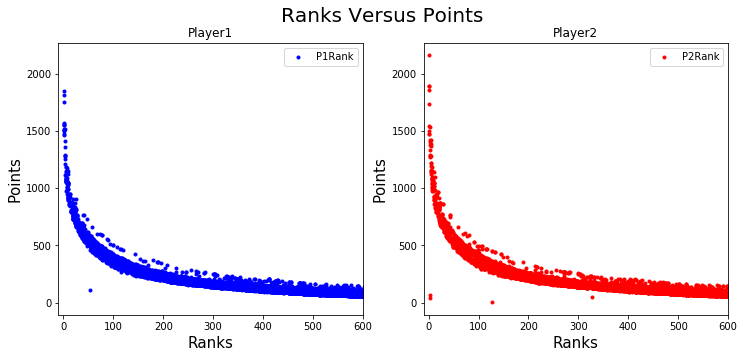

In [29]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,5))
fig.suptitle('Ranks Versus Points',fontsize = 20)
df.plot( x='P1Pts',y='P1Rank',style='.', color = 'blue', ax=ax1)
df.plot(x='P2Pts',y='P2Rank',style='.', color = 'red', ax=ax2)
ax1.set_title('Player1')
ax2.set_title('Player2')
ax1.set_xlabel('Ranks', fontsize = 15) # x-axis label with fontsize 15
ax1.set_ylabel('Points', fontsize = 15) # y-axis label with fontsize 15
ax2.set_xlabel('Ranks', fontsize = 15) # x-axis label with fontsize 15
ax2.set_ylabel('Points', fontsize = 15) # y-axis label with fontsize 15
ax1.set_xlim(-10,600)
ax2.set_xlim(-10,600)

I'll now compare the frequency of Ranks when Player1 wins and when Player2 wins.

after consulting the two histogarmes the conclusion I come to the following conclusion: before rank 50 the players win more games than they lose. however after rank 50 players lose more matches than they win

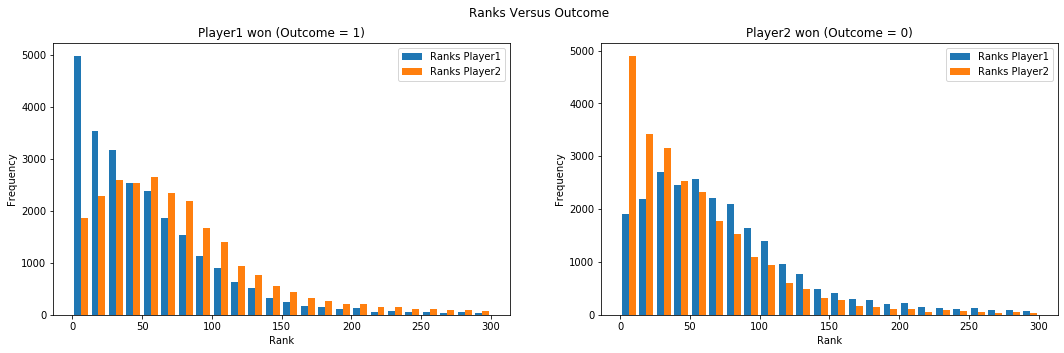

In [31]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(18,5))
fig.suptitle('Ranks Versus Outcome')
bins = np.linspace(0, 300, 25)
ax1.hist([df[df['Outcome']==1]['P1Rank'],df[df['Outcome']==1]['P2Rank'] ],
         bins = bins, label=['Ranks Player1', 'Ranks Player2'])
ax2.hist([df[df['Outcome']==0]['P1Rank'],df[df['Outcome']==0]['P2Rank'] ],
         bins = bins, label=['Ranks Player1', 'Ranks Player2'])
ax1.set_title('Player1 won (Outcome = 1)')
ax2.set_title('Player2 won (Outcome = 0)')
ax1.set_xlabel('Rank')
ax2.set_xlabel('Rank')
ax1.set_ylabel('Frequency')
ax2.set_ylabel('Frequency')
ax1.legend(loc='upper right')
ax2.legend(loc='upper right')
plt.show()

#### Discovring distribution of matches by location


I note that the location that hosted the most matches ('Paris') organized more than 3000 games. and the location which hosted the fewest matches ('Lisbone') organized less than 25 matches.

Text(0, 0.5, 'Number of Macthes')

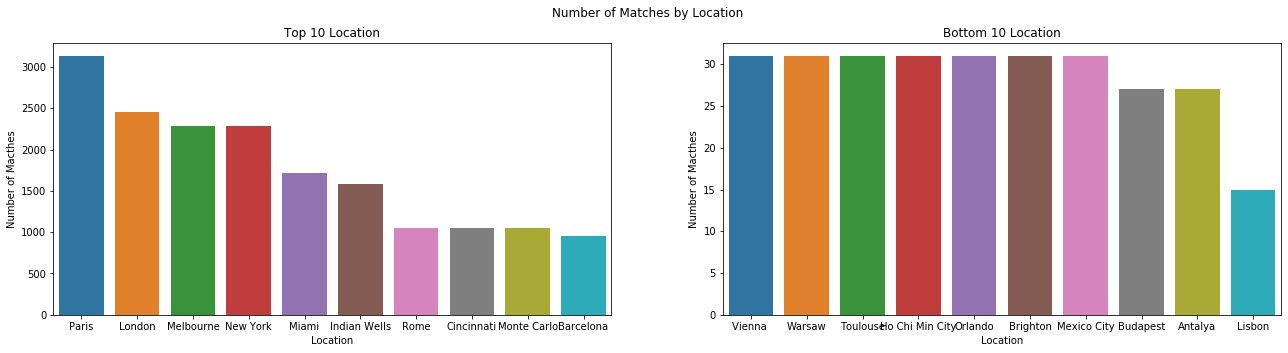

In [32]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(22,5))
fig.suptitle('Number of Matches by Location')
ax1 = sns.countplot(x='Location',data=df,order = df['Location'].value_counts().index[:10],ax=ax1)
ax1.set_title('Top 10 Location')
ax1.set_ylabel('Number of Macthes')
ax2 = sns.countplot(x='Location',data=df,order = df['Location'].value_counts().index[-10:],ax=ax2)
ax2.set_title('Bottom 10 Location')
ax2.set_ylabel('Number of Macthes')
#plt.xticks(rotation=90)

#### Discovring distribution of matches by Court

I note that the majority of matches took place on an outdoor court, which means that the feature 'Court' is not very important in prediction. 

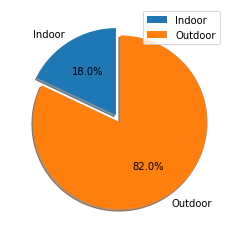

In [33]:
sizes  = df.groupby(['Court']).size().values
labels = df['Court'].unique()[::-1]
explode = (0, 0.1)

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', explode =explode , shadow=True, startangle=90)
ax.legend(loc='upper right')
plt.show()

### Categorical Variable Encoding

Next, I encode the Categorical Variables. Most of the Machine learning algorithms can not handle categorical variables unless they are converted to numerical values and many algorithm’s performance varies based on how categorical variables are encoded.

I first list the categorical columns, and how many separate variables contain

In [34]:
print('The categorical columns are : \n\n', list(df.select_dtypes(include=['object']).columns))
print('---'*35)
print(df.describe(include=['O']))
categorical_col = df.select_dtypes(include=['object']).columns
print('---'*35)
print('\n Number of separate variable in each categorical variable : \n\n')
for i in categorical_col:
    print('Column {} contain {} separate variables\n'.format(str(i), str(len(df.groupby([i]).size()))))

The categorical columns are : 

 ['Player1', 'Player2', 'Comment', 'Court', 'Location', 'Loser', 'Round', 'Series', 'Surface', 'Tournament', 'Winner']
---------------------------------------------------------------------------------------------------------
           Player1     Player2    Comment    Court Location     Loser  \
count        49663       49663      49663    49663    49663     49663   
unique        1193        1209          5        2      114      1437   
top     Federer R.  Federer R.  Completed  Outdoor    Paris  Lopez F.   
freq           652         642      47805    40731     3132       394   

            Round         Series Surface Tournament      Winner  
count       49663          49663   49663      49663       49663  
unique          8              8       4        210         909  
top     1st Round  International    Hard    US Open  Federer R.  
freq        23030          12204   26215       2286        1072  
-----------------------------------------------

I look closely separate variables of 'Comment' feature and I notice that the variables Disqualified, Retired, Sched and Walkover are rarely present compared to Completed. I can group them under one name 'Incompleted'. 

In [35]:
print(' Original distribution of number of Comment features : \n ')
a = df.groupby(['Comment']).size()
print(a)
print('--'*15)
df = df.replace(list(a.index)[1:], 'Incompleted')
print(' Modified distribution of number of Comment features : \n ', df.groupby(['Comment']).size())

 Original distribution of number of Comment features : 
 
Comment
Completed       47805
Disqualified        1
Retired          1612
Sched               1
Walkover          244
dtype: int64
------------------------------
 Modified distribution of number of Comment features : 
  Comment
Completed      47805
Incompleted     1858
dtype: int64


##### Categorical Variable Encoding

Player1 and Player2 features are relatively non-standard, may not contribute directly to survival, so maybe dropped. The same for the features ['Loser','Winner'] which are unknowable before the end of the match.

In [36]:
df.drop(['Player1','Player2','Loser','Winner'] , axis=1, inplace=True)

Most of the Machine learning algorithms can not handle categorical variables unless they are converted to numerical values and many algorithm’s performance varies based on how Categorical variables are encoded.

I will use Pandas and category_encoders (Scikit-learn contribution library) to encode my categorical variables : 

#### One Hot Encoding

In this method, I map each category to a vector that contains 1 and 0 denoting the presence or absence of the feature. The number of vectors depends on the number of categories for a feature. This method produces a lot of columns that slows down the learning significantly if number of category is very high for the feature. therefore, I will use this method for features that contain the least amount of separate variables, namely,$ ['Comment', 'Court','Round,'Series', Surface]$

In [37]:
#One Hot Encoding

df = pd.get_dummies(df, columns=['Comment', 'Court','Round','Series', 'Surface'])
df.columns

Index(['B365P1', 'B365P2', 'EXP2', 'PSP1', 'PSP2', 'P1Pts', 'P1Rank', 'P2Pts',
       'P2Rank', 'Outcome', 'Best of', 'NuMatchesP1', 'NuMatchesP2',
       'WinsRatioP1', 'WinsRatioP2', 'P1Wins', 'P2Wins', 'P1WinsTR',
       'P2WinsTR', 'LengthNameP1', 'LengthNameP2', 'Date', 'Location',
       'Tournament', 'Comment_Completed', 'Comment_Incompleted',
       'Court_Indoor', 'Court_Outdoor', 'Round_1st Round', 'Round_2nd Round',
       'Round_3rd Round', 'Round_4th Round', 'Round_Quarterfinals',
       'Round_Round Robin', 'Round_Semifinals', 'Round_The Final',
       'Series_ATP250', 'Series_ATP500', 'Series_Grand Slam',
       'Series_International', 'Series_International Gold', 'Series_Masters',
       'Series_Masters 1000', 'Series_Masters Cup', 'Surface_Carpet',
       'Surface_Clay', 'Surface_Grass', 'Surface_Hard'],
      dtype='object')

In [38]:
# Define input and output

X = df.drop('Outcome', axis=1)
y = df['Outcome']

##### Hashing Encoder

Category_encoders is a scikit-learn-contrib module of transformers for encoding categorical data. As a scikit-learn-contrib module, category_encoders is fully compatible with the
scikit-learn API. It also uses heavily the tools provided by scikitlearn itself.

HashingEncoder implements the hashing trick. It is similar to one-hot encoding but with fewer new dimensions and some info loss due to collisions. The collisions do not significantly affect performance unless there is a great deal of overlap. An excellent discussion of the hashing trick and guidelines for selecting the number of output features can be found in https://booking.ai/dont-be-tricked-by-the-hashing-trick-192a6aae3087

In [39]:
# Hashing Encoder

ce_hash = ce.HashingEncoder(cols=['Location', 'Tournament'])
X = ce_hash.fit_transform(X,y)

In [40]:
#separating train (2000-2016) and test (2017) sets

training_date = datetime.datetime(2016,12,31)
X_train = X[X['Date']<=training_date].drop(['Date'], axis=1)
y_train = y[X['Date']<=training_date]
X_test = X[X['Date']>training_date].drop(['Date'], axis=1)
y_test = y[X['Date']>training_date]

In [41]:
print('The shape of X_train : ', X_train.shape)
print('The shape of y_train : ', y_train.shape)
print('The shape of X_test : ', X_test.shape)
print('The shape of y_test : ', y_test.shape)

The shape of X_train :  (47028, 52)
The shape of y_train :  (47028,)
The shape of X_test :  (2635, 52)
The shape of y_test :  (2635,)


Normalization (min-max scaling):
* It makes values  scaled to a fixed range (0-1).

In [42]:
# normalization

scalerX = MinMaxScaler(feature_range=(0, 1))
X_train[X_train.columns] = scalerX.fit_transform(X_train[X_train.columns])
X_test[X_test.columns] = scalerX.transform(X_test[X_test.columns])

In [51]:
# Logistic Regression

logreg = LogisticRegression(max_iter=1000)
grid_values = {'penalty': ['l2'], 'C':[0.001,0.01,1,5,10,25],
              'solver': ['saga','lbfgs']}
grid_logreg = GridSearchCV(logreg, param_grid = grid_values, scoring = 'accuracy')
grid_logreg.fit(X_train, y_train)
y_pred_log = grid_logreg.predict(X_test)
acc_log_train = round(grid_logreg.score(X_train, y_train) * 100, 2)
acc_log_test = round(accuracy_score(y_test,y_pred_log) * 100, 2)
print('Accuracy score for training dataset using LogisticRegression is : ', str(acc_log_train))
print('Accuracy score for testing dataset using LogisticRegression is :  ',str(acc_log_test))

/Users/hajjimohammed/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Accuracy score for training dataset using LogisticRegression is :  80.1
Accuracy score for testing dataset using LogisticRegression is :   67.4


In [52]:
# K-Nearest Neighbors

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
grid_values = {'n_neighbors': [3, 5, 7, 11, 15, 21, 33, 45, 75, 99, 157, 255]}
grid_knn = GridSearchCV(knn, param_grid = grid_values, scoring = 'accuracy')
grid_knn.fit(X_train, y_train)
y_pred_knn = grid_knn.predict(X_test)
acc_knn_train = round(grid_knn.score(X_train, y_train) * 100, 2)
acc_knn_test = round(accuracy_score(y_test,y_pred_knn) * 100, 2)
print('Accuracy score for training dataset using KNeighborsClassifier is : ', str(acc_knn_train))
print('Accuracy score for testing dataset using KNeighborsClassifier is :  ',str(acc_knn_test))

/Users/hajjimohammed/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Accuracy score for training dataset using KNeighborsClassifier is :  66.93
Accuracy score for testing dataset using KNeighborsClassifier is :   60.76


In [53]:
# Support Vector Machines

svc = SVC()
grid_values = {'kernel': ['rbf'], 'C':[0.001,0.01,1,5,10,15]}
grid_svc = GridSearchCV(svc, param_grid = grid_values, scoring = 'accuracy')
grid_svc.fit(X_train, y_train)
y_pred_svc = grid_svc.predict(X_test)
acc_svc_train = round(grid_svc.score(X_train, y_train) * 100, 2)
acc_svc_test = round(accuracy_score(y_test,y_pred_svc) * 100, 2)
print('Accuracy score for training dataset using SVC is : ', str(acc_svc_train))
print('Accuracy score for testing dataset using SVC is : ',str(acc_svc_test ))

/Users/hajjimohammed/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/hajjimohammed/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/hajjimohammed/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/hajjimohammed/opt/anaconda3/lib/python3.7/site-packages/sklearn/sv

Accuracy score for training dataset using SVC is :  80.26
Accuracy score for testing dataset using SVC is :  66.53


In [54]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(X_train, y_train)
y_pred_gaussian = gaussian.predict(X_test)
acc_gaussian_train = round(gaussian.score(X_train, y_train) * 100, 2)
acc_gaussian_test = round(accuracy_score(y_test, y_pred_gaussian) * 100, 2)
print('Accuracy score for training dataset using GaussianNB is : ', str(acc_gaussian_train))
print('Accuracy score for testing dataset using GaussianNB is : ', str(acc_gaussian_test))

Accuracy score for training dataset using GaussianNB is :  72.83
Accuracy score for testing dataset using GaussianNB is :  66.94


In [56]:
# Perceptron

perceptron = Perceptron()
grid_values = {'penalty': ['l2','l1','elasticnet'], 'alpha': [0.0001,0.001,0.01,0.1,0.5,1,5, 10]}
grid_percept = GridSearchCV(perceptron, param_grid = grid_values, scoring = 'accuracy')
grid_percept.fit(X_train, y_train)
y_pred_percept = grid_percept.predict(X_test)
acc_perceptron_train = round(grid_percept.score(X_train, y_train) * 100, 2)
acc_perceptron_test = round(accuracy_score(y_test, y_pred_percept) * 100, 2)
print('Accuracy score for training dataset using Perceptron is : ', str(acc_perceptron_train))
print('Accuracy score for testing dataset using Perceptron is : ', str(acc_perceptron_test))

/Users/hajjimohammed/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Accuracy score for training dataset using Perceptron is :  71.35
Accuracy score for testing dataset using Perceptron is :  65.5


In [57]:
# Linear SVC

linear_svc = LinearSVC()
grid_values = {'C':[0.001,0.01,1,5,10,15]}
grid_linear_svc = GridSearchCV(linear_svc, param_grid = grid_values, scoring = 'accuracy')
grid_linear_svc.fit(X_train, y_train)
y_pred_linear_svc = grid_linear_svc.predict(X_test)
acc_linear_svc_train = round(grid_linear_svc.score(X_train, y_train) * 100, 2)
acc_linear_svc_test = round(accuracy_score(y_test, y_pred_linear_svc) * 100, 2)
print('Accuracy score for training dataset using LinearSVC is : ', str(acc_linear_svc_train))
print('Accuracy score for testing dataset using LinearSVC is : ', str(acc_linear_svc_test))

/Users/hajjimohammed/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/hajjimohammed/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/hajjimohammed/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/hajjimohammed/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/hajjimohammed/opt/anaconda3/lib/python3.7/site-p

Accuracy score for training dataset using LinearSVC is :  79.7
Accuracy score for testing dataset using LinearSVC is :  67.86


/Users/hajjimohammed/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [63]:
# Stochastic Gradient Descent

sgd = SGDClassifier(max_iter=5000)
grid_values = {'loss': ['hinge', 'squared_hinge', 'perceptron'],
               'penalty':['l2', 'elasticnet'], 'alpha': [0.01,0.1,0.5,1,3],
              'l1_ratio': [0.01,0.15,0.3,0.6,0.9]}
grid_sgd = GridSearchCV(sgd, param_grid = grid_values, scoring = 'accuracy')
grid_sgd.fit(X_train, y_train)
y_pred_sgd = grid_sgd.predict(X_test)
acc_sgd_train = round(grid_sgd.score(X_train, y_train) * 100, 2)
acc_sgd_test = round(accuracy_score(y_test, y_pred_sgd) * 100, 2)
print('Accuracy score for training dataset using SGDClassifier is : ', str(acc_sgd_train))
print('Accuracy score for testing dataset using SGDClassifier is : ', str(acc_sgd_test))

/Users/hajjimohammed/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/hajjimohammed/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Users/hajjimohammed/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Users/hajjimohammed/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing m

/Users/hajjimohammed/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Users/hajjimohammed/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Users/hajjimohammed/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Users/hajjimohammed/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to imp

Accuracy score for training dataset using SGDClassifier is :  68.41
Accuracy score for testing dataset using SGDClassifier is :  64.36


In [64]:
# Decision Tree Classifier

dc_tree = DecisionTreeClassifier()
grid_values = {'criterion': ['gini', 'entropy'], 'splitter' : ['best', 'random']}
grid_dc_tree = GridSearchCV(dc_tree, param_grid = grid_values, scoring = 'accuracy')
grid_dc_tree.fit(X_train, y_train)
y_pred_dc_tree = grid_dc_tree.predict(X_test)
acc_dc_tree_train = round(grid_sgd.score(X_train, y_train) * 100, 2)
acc_dc_tree_test = round(accuracy_score(y_test, y_pred_dc_tree) * 100, 2)
print('Accuracy score for training dataset using DecisionTreeClassifier is : ', str(acc_dc_tree_train))
print('Accuracy score for testing dataset using DecisionTreeClassifier is : ', str(acc_dc_tree_test))

/Users/hajjimohammed/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Accuracy score for training dataset using DecisionTreeClassifier is :  68.41
Accuracy score for testing dataset using DecisionTreeClassifier is :  60.08


In [65]:
# Random Forest Classifier

random_forest = RandomForestClassifier(n_estimators=500)
random_forest.fit(X_train, y_train)
y_pred_rd_forest = random_forest.predict(X_test)
acc_rd_forest_train = round(random_forest.score(X_train, y_train) * 100, 2)
acc_rd_forest_test = round(accuracy_score(y_test, y_pred_rd_forest) * 100, 2)
print('Accuracy score for training dataset using RandomForestClassifier is : ', str(acc_rd_forest_train))
print('Accuracy score for testing dataset using RandomForestClassifier is : ', str(acc_rd_forest_test))

Accuracy score for training dataset using RandomForestClassifier is :  100.0
Accuracy score for testing dataset using RandomForestClassifier is :  67.97


### Model Evaluation

We can now rank our evaluation of all the models to choose the best one for our problem.

In [67]:

models = pd.DataFrame({
    'Model': ['Logistic Regression','KNN', 'Support Vector Machines',
              'Naive Bayes', 'Perceptron', 'Linear SVC',
              'Stochastic Gradient Decent', 'Decision Tree',
              'Random Forest'],
    'ScoreTraining': [acc_log_train, acc_knn_train, acc_svc_train,
                      acc_gaussian_train, acc_perceptron_train, acc_linear_svc_train,
                      acc_sgd_train, acc_dc_tree_train,
                     acc_rd_forest_train],
    'ScoreTesting': [acc_log_test, acc_knn_test, acc_svc_test,
                     acc_gaussian_test, acc_perceptron_test, acc_linear_svc_test,
                     acc_sgd_test, acc_dc_tree_test,
                     acc_rd_forest_test]})
models.sort_values(by='ScoreTesting', ascending=False)

,Model,ScoreTraining,ScoreTesting
8,Random Forest,100.00,67.97
5,Linear SVC,79.70,67.86
0,Logistic Regression,80.10,67.40
3,Naive Bayes,72.83,66.94
2,Support Vector Machines,80.26,66.53
4,Perceptron,71.35,65.50
6,Stochastic Gradient Decent,68.41,64.36
1,KNN,66.93,60.76
7,Decision Tree,68.41,60.08


The model which seems to give the best accuracy and avoids the most overfitting is Naive Bayes

## Answers :

1. Who are the three ATP players with the most wins ?

In [68]:
df_atp.groupby(["Winner"]).size().sort_values(ascending=False)[:3]

Winner
Federer R.     1121
Nadal R.        891
Djokovic N.     802
dtype: int64

2. How many sets did the player “Federer R.” win in total ?

In [69]:
str(df_atp[df_atp["Winner"] == "Federer R."]["Wsets"].sum() +
    df_atp[df_atp["Loser"] == "Federer R."]["Lsets"].sum())

'2714.0'

3. How many sets did the player “Federer R.” win during the years 2016 and 2017 ?

In [70]:
date_min = datetime.datetime(2015, 12, 31)
date_max = datetime.datetime(2018,1,1)
df_atp[(df_atp["Winner"] == "Federer R.") & (date_min < df_atp["Date"]) & 
       (df_atp["Date"]< date_max)]["Wsets"].sum() + df_atp[(df_atp["Loser"] ==
                                                           "Federer R.") & (date_min < df_atp["Date"]) &
                                                          (df_atp["Date"]< date_max)]["Lsets"].sum()

184.0

4. For each match, what is the percentage of victories of the winner in the past ?

In [71]:
def percentage_victories(winner, date, dataset):
    num_matches_before = len(dataset[((dataset.Winner == winner ) | (dataset.Loser == winner))
                                     & (dataset.Date < date)])
    num_victories_before = len(dataset[(dataset.Winner == winner )
                                     & (dataset.Date < date)])
    try:
        return num_victories_before/num_matches_before
    except ZeroDivisionError:
        return 0

In [72]:
df_atp['PercentageVictWinner'] = df_atp.swifter.apply(lambda x:
                                                      percentage_victories(x.Winner,x.Date,df_atp), axis=1)

/Users/hajjimohammed/opt/anaconda3/lib/python3.7/site-packages/tqdm/std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
